**Nome:** Iran Freitas Ribeiro

**Matrícula:** 2021241588

**Disciplina:** TEI - Estatística Aplicada

**Professor:** Celso José Munaro

In [81]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import OLS, ccf

In [14]:
# x, y
Z = pd.read_csv("Data_epc10.csv", sep=";", header=None)
Z = Z.values
Ztreino_R = Z[:300]
ZCC_treino = Z[300:600]
ZCC_normal = Z[600:1200]
ZCC_falha = Z[1200:]

In [21]:
Ztreino_R

dtype('float64')

# Questão 1

In [36]:
X1 = Ztreino_R[:, 0]
Y1 = Ztreino_R[:, 1]

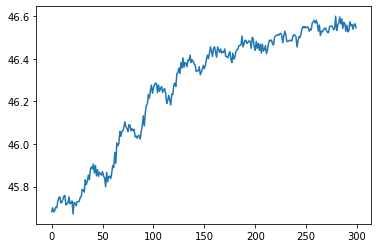

In [52]:
plt.plot(X1)

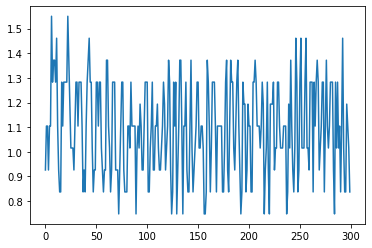

In [53]:
plt.plot(Y1)

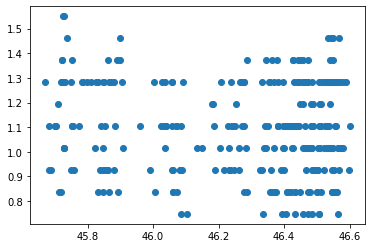

In [51]:
plt.scatter(X1, Y1)

In [37]:
Xr = sm.add_constant(X1)
m1 = OLS(Y1, Xr)
res1 = m1.fit()

In [59]:
res1.params

array([ 3.8133477 , -0.05875932])

In [60]:
b0, b1 = res1.params

In [61]:
b0

3.813347696735804

In [67]:
y_hat = [(b0 + b1*xi) for xi in X1]

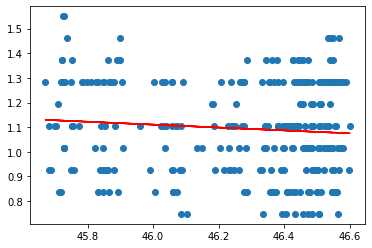

In [69]:
plt.scatter(X1, Y1)
plt.plot(X1, y_hat, c='red')

# Questão 2

In [9]:
X1 = Ztreino_R[:, 0]
Y1 = Ztreino_R[:, 1]

In [10]:
X1r = sm.add_constant(X1)
m1 = OLS(Y1, X1r)
res1 = m1.fit()

In [11]:
res1.params

array([ 3.8133477 , -0.05875932])

In [12]:
X2c = ZCC_treino[:, 0]
Y2c = ZCC_treino[:, 1]
b0, b1 = res1.params
# previsao de y usando X de ZCC_treino
Y_hat = [b0 + b1*xi for xi in X2c]
residuos_zc = [yi - yi_hat for yi, yi_hat in zip(Y2c,Y_hat)]

In [21]:
norm.pdf(1.5)

0.12951759566589174

In [22]:
def controle(media, desvio, n, s=3):
    desvio_a = desvio/np.sqrt(n)
    ucl = media + s*desvio_a
    lcl = media - s*desvio_a
    return ucl, lcl

In [41]:
media, std = np.mean(residuos_zc), np.std(residuos_zc)
n = 5
ucl2, lcl2 = controle(media, std, n)

- Selecionar um número $n$ de amostras de ZCC_treino para obter os resíduos (ucl e lcl)
    - Calcular limites de controle
- Verificar FDR e FAR usando as bases ZCC_normal (true negative) e ZCC_falha (true positive)

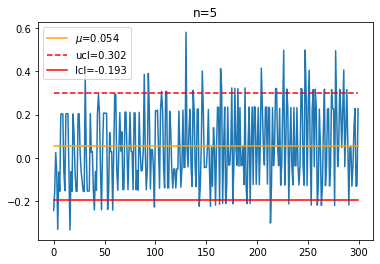

In [43]:
fig, ax = plt.subplots()
x = np.arange(300)
ax.plot(x, residuos_zc)
ax.plot([0, 299], [media, media], c='orange', label=r'$\mu$={:.3f}'.format(media))
ax.plot([0, 299], [ucl2, ucl2], ls='--', c='red', label='ucl={:.3f}'.format(ucl2))
ax.plot([0, 299], [lcl2, lcl2], c='red', label='lcl={:.3f}'.format(lcl2))
plt.title("n={}".format(n))
plt.legend();